In [1]:
drive=False
if drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Font Classification Project

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.run_functions_eagerly(True)

Num GPUs Available:  1


Working with tensorflow and local GPU (GTX 1070)

## Functions for data generation

In [3]:
import h5py
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sklearn
import sklearn.model_selection

In [4]:
input_height=64
input_width=64

In [5]:
def fonts_to_output(fonts, label_encoder):
    label = label_encoder.transform(fonts)
    return tf.keras.utils.to_categorical(label, 7)

In [6]:
def crop_wrap_letter(img, bounding_box):
    src=bounding_box
    input_pts = np.float32(src)
    # y comes first in the matrix
    output_pts = np.float32([[0, 0],
                            [input_height - 1, 0],
                            [input_height - 1, input_width - 1],
                            [0, input_width - 1]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(img,
                          M,
                          (input_width, input_height),
                          flags=cv2.INTER_LINEAR)
    return out

In [7]:
def crop_wrap_image(img, charBB, fonts, label_encoder=None):
    mini_batch = []
    for i in range(fonts.shape[0]):
        bounding_box = np.dstack(charBB[:,:,i])[0]  # pairs of x,y
        crop = tf.keras.applications.resnet50.preprocess_input(crop_wrap_letter(img, bounding_box))  # Identify as 1 batch of image
        mini_batch.append(crop)
        crop = crop.reshape((1,input_height,input_width,3))  # Identify as 1 batch of image
        # if not label_encoder:
        #     yield crop
        # else:
        #     yield crop, fonts_to_output([fonts[i]], label_encoder)
    mini_batch = np.asarray(mini_batch)
    if not label_encoder:
        yield mini_batch
    else:
        yield mini_batch, fonts_to_output(fonts, label_encoder)

In [8]:
def crop_wrap_data(db, im_names, label_encoder=None):
    for im in im_names:
        img = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        
        yield from crop_wrap_image(img, charBB, fonts, label_encoder)

In [9]:
def data_generator(*args, **kwargs):
    while True:
        yield from crop_wrap_data(*args, **kwargs)

In [10]:
def font_label_data(db, im_names, label_encoder=None):
    for im in im_names:
        font = db['data'][im].attrs['font']
        
        for f in font:
            if not label_encoder:
                yield f
            else:
                yield fonts_to_output([f], label_encoder)

In [11]:
def load_db():
    path = 'SynthText.h5' if not drive else '/content/drive/MyDrive/Fonter/SynthText.h5'
    db = h5py.File(path, 'r')
    im_names = list(db['data'].keys())
    return db, im_names

In [12]:
def data_size(db, im_names):
    size = 0
    for im in im_names:
        font = db['data'][im].attrs['font']
        size += len(font)
    return size

## Prepare the data

In [13]:
db, im_names = load_db()

In [14]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(font_label_data(db, im_names)))
label_encoder.classes_, len(label_encoder.classes_)

(array([b'Alex Brush', b'Michroma', b'Open Sans', b'Raleway', b'Roboto',
        b'Russo One', b'Ubuntu Mono'], dtype='|S11'),
 7)

In [15]:
partial_data, _ = sklearn.model_selection.train_test_split(im_names, test_size=0.99, random_state = 42)  # testing purposes

In [16]:
X_train, X_test = sklearn.model_selection.train_test_split(partial_data, test_size=0.2, random_state = 42)

In [17]:
X_train, X_val = sklearn.model_selection.train_test_split(X_train, test_size=0.1, random_state = 42)

In [18]:
train_data_and_labels = data_generator(db, X_train, label_encoder=label_encoder)
val_data_and_labels = data_generator(db, X_val, label_encoder=label_encoder)
test_data = data_generator(db, X_test)
test_labels = label_encoder.transform(list(font_label_data(db, X_test)))

In [19]:
# size = data_size(db, X_train)
# for i, (img, label) in enumerate(train_data_and_labels):
#     if i>=size*3:
#         break
#     if i%size!=0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape((input_height,input_width,3)))
#     plt.title(label[0])

## Define a model

In [20]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(input_height,input_width,3))

In [21]:
# Freeze the layers which you don't want to train. Here I am freezing the all layers.
resnet.trainable = False
resnet.training = False

In [22]:
# inputs = tf.keras.Input(shape=(input_height, input_width, 3))
# x = resnet(inputs, training=False)
# # x = tf.keras.layers.GlobalAveragePooling2D()(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
# fonter = tf.keras.Model(inputs, outputs)

# # # ###could be defined as Sequential I think..

In [23]:
fonter = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(input_height,input_width,3)),
    resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax"),
])

In [24]:
base_learning_rate = 0.001
opt = tf.keras.optimizers.Nadam(learning_rate=base_learning_rate)
fonter.compile(optimizer=opt,
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

In [25]:
fonter.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                          

## Train Model

In [26]:
initial_epochs = 10
loss0, accuracy0 = fonter.evaluate(crop_wrap_data(db, X_val, label_encoder=label_encoder))

1/1 [==============================] - 8s 8s/step - loss: 2.1040 - accuracy: 0.0732


In [27]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [28]:
# d=list(crop_wrap_data(db, X_train, label_encoder))
# imgs=np.array([x[0][0] for x in d])
# labels=np.array([x[1][0] for x in d])

In [29]:
history = fonter.fit(train_data_and_labels,
                    epochs=initial_epochs,
                    validation_data=val_data_and_labels,
                    max_queue_size=1,
                    steps_per_epoch=data_size(db, X_train),
                    validation_steps=data_size(db, X_val)
                    )

Epoch 1/10
142/142 [==============================] - 11s 53ms/step - loss: 2.3835 - accuracy: 0.1719 - val_loss: 1.6103 - val_accuracy: 0.1707
Epoch 2/10
142/142 [==============================] - 6s 45ms/step - loss: 2.2186 - accuracy: 0.1960 - val_loss: 1.7830 - val_accuracy: 0.1707
Epoch 3/10
142/142 [==============================] - 6s 45ms/step - loss: 2.1012 - accuracy: 0.1937 - val_loss: 1.8651 - val_accuracy: 0.0732
Epoch 4/10
142/142 [==============================] - 6s 45ms/step - loss: 2.0116 - accuracy: 0.2012 - val_loss: 1.5895 - val_accuracy: 0.2195
Epoch 5/10
142/142 [==============================] - 6s 45ms/step - loss: 1.9548 - accuracy: 0.2029 - val_loss: 1.6903 - val_accuracy: 0.1707
Epoch 6/10
142/142 [==============================] - 6s 45ms/step - loss: 1.9368 - accuracy: 0.2040 - val_loss: 1.6922 - val_accuracy: 0.1707
Epoch 7/10
142/142 [==============================] - 6s 45ms/step - loss: 1.9389 - accuracy: 0.2015 - val_loss: 1.6936 - val_accuracy: 0.170

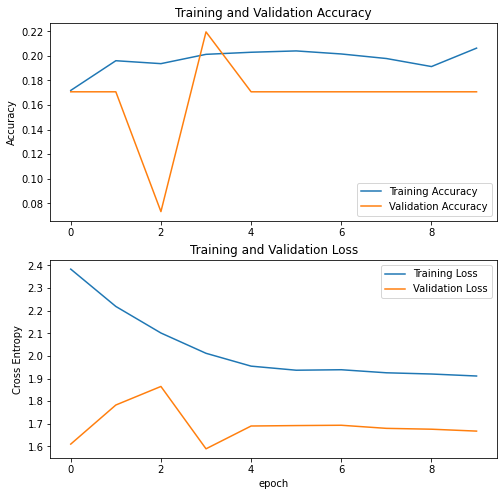

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
imgs.shape

NameError: name 'imgs' is not defined

In [ ]:
fonter.evaluate(imgs, labels, batch_size=1)

In [ ]:
predictions = fonter.predict(imgs)

In [ ]:
np.argmax(predictions, axis=1)

In [ ]:
np.argmax(labels, axis=1)

In [ ]:
for i, (img, label) in enumerate(val_data_and_labels):
    if i==data_size(db, X_val)*2:
        break
    plt.figure()
    plt.imshow(img.reshape((input_height,input_width,3)))
    plt.title(label[0])

In [ ]:
X_train

In [ ]:
im_names.index(X_val[0])

In [ ]:
im_names.index(X_train[-1])

In [ ]:
im_names.index(X_test[0])